In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support
)
import time
import logging

# --------------------- Optional: Mixed Precision ---------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
# ---------------------------------------------------------------------

# --------------------- Optimizations ---------------------
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER = 250  # Increased for more randomness
# ---------------------------------------------------------------------

# Set up logging for any preprocessing errors
logging.basicConfig(filename="preprocessing_errors.log", level=logging.ERROR)

# Define paths
base_folder = r"C:\Users\Manas\IoT Research Models\ODIR-5K\ODIR-5K"
xlsx_path = r"C:\Users\Manas\IoT Research Models\full_df.xlsx"  # Dataset Excel file

# Load the dataset
df = pd.read_excel(xlsx_path)
labels_list = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
df['target'] = df[labels_list].idxmax(axis=1)

# Prepare image file paths and corresponding targets.
# Assumes that 'Left-Fundus' and 'Right-Fundus' columns contain preprocessed file paths.
left_paths = df['Left-Fundus'].dropna().tolist()
right_paths = df['Right-Fundus'].dropna().tolist()
all_paths = left_paths + right_paths
patient_targets = df['target'].dropna().tolist()
all_targets = patient_targets + patient_targets  # Duplicate for left & right images

# Filter out invalid paths
valid_paths = [p for p in all_paths if os.path.isfile(p)]
if len(valid_paths) == 0:
    raise ValueError("No valid images found. Please check the dataset.")

# Map textual labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(labels_list)}
target_indices = [label_to_index[label] for label in all_targets]

# Split dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    valid_paths, target_indices, test_size=0.2, random_state=42
)
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

# --- Build tf.data Pipeline ---
IMG_SIZE = 299  # InceptionV3 expects 299x299 images by default
BATCH_SIZE = 16  # Adjust this based on available GPU memory

def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    try:
        image = tf.image.decode_jpeg(image, channels=3)
    except Exception as e:
        tf.print(f"Error decoding {file_path}: {e}")
        image = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Data augmentation: pad, random crop, flip, brightness adjustment
def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+20, IMG_SIZE+20)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_dataset(file_paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(X_train_paths, y_train, training=True)
val_ds = create_dataset(X_val_paths, y_val, training=False)

# Diagnostic: Check one batch
start = time.time()
for batch in train_ds.take(1):
    images_batch, labels_batch = batch
    print("One batch shape:", images_batch.shape)
end = time.time()
print("Time taken for one batch:", end - start, "seconds")

# --- Build the Model using InceptionV3 ---
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# --- Training ---
print("Starting training...")
start_time = time.time()
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
training_time = time.time() - start_time

model.save("ocular_disease_inceptionv3_model.h5")
print("✅ Model saved as 'ocular_disease_inceptionv3_model.h5'")

# --- Evaluation ---
loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"✅ Validation Accuracy: {val_accuracy*100:.2f}%")

y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in val_ds], axis=0), axis=1)

roc_score = roc_auc_score(np.concatenate([y for _, y in val_ds], axis=0), y_pred, multi_class='ovr')
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

num_params = model.count_params()
num_layers = len(model.layers)

print("\n--- Metrics for Comparative Study ---")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"ROC AUC Score: {roc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Number of Parameters: {num_params}")
print(f"Training Time (seconds): {training_time:.2f}")
print(f"Number of Layers: {num_layers}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels_list))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
One batch shape: (16, 299, 299, 3)
Time taken for one batch: 0.7095248699188232 seconds
Starting training...
Epoch 1/50
640/640 [==============================] - 109s 136ms/step - loss: 1.6917 - accuracy: 0.3823 - val_loss: 1.3294 - val_accuracy: 0.4744 - lr: 1.0000e-04
Epoch 2/50
640/640 [==============================] - 231s 361ms/step - loss: 1.3783 - accuracy: 0.4643 - val_loss: 1.2767 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 3/50
640/640 [==============================] - 154s 241ms/step - loss: 1.2747 - accuracy: 0.5010 - val_loss: 1.2479 - val_accuracy: 0.5029 - lr: 1.0000e-04
Epoch 4/50
640/640 [==============================] - 147s 230ms/step - loss: 1.2103 - accuracy: 0.5263 - val_loss: 1.2070 - val_accuracy: 0.5205 - lr

In [2]:
metrics = {
    "Accuracy": val_accuracy,
    "ROC Score": roc_score,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score,
    "Number of Parameters": num_params,
    "Training Time (seconds)": training_time,
    "Number of Layers": num_layers
}

# Save metrics to a CSV file
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("Model_metrics_InceptionV3.csv", index=False)
print("✅ Metrics saved to 'Model_metrics_InceptionV3.csv'")

✅ Metrics saved to 'Model_metrics_VGG.csv'


Model summary saved to 'model_summary_inceptionv3.txt'.
Training curves saved to 'inceptionv3_eval.png'.


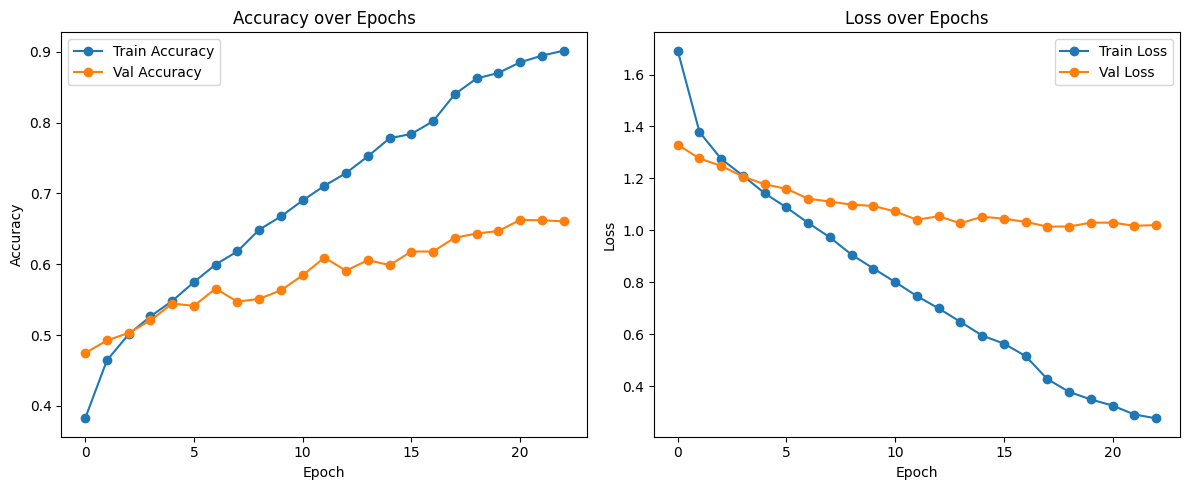

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # Correctly import load_model

# Load your model
model = load_model("ocular_disease_inceptionv3_model.h5")

# Save model summary to a text file
with open('model_summary_inceptionv3.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved to 'model_summary_inceptionv3.txt'.")

# Plot training curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig('inceptionv3_eval.png')  # Save the training curves plot
print("Training curves saved to 'inceptionv3_eval.png'.")
plt.show()

In [4]:
last_epoch_accuracy = history.history['accuracy'][-1]
print(f"Accuracy at the last epoch: {last_epoch_accuracy:.4f}")

Accuracy at the last epoch: 0.9015
